# Discovery of Reticular Materials for C0<sub>2</sub> Capture

## 0. Necessary Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
import os
import sys
import tempfile
import subprocess

import math
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import nglview as nv

from IPython.display import display

from pymatgen.core.structure import Structure
from pymatgen.core.periodic_table import Element
from material import MaterialBuilder, RMSDMask, AngleMask, CombinedMask
from gflow.environment import SequenceEnvironment
from gflow.agent import TrajectoryBalanceGFlowNet
from gflow.model import LSTM

sns.set_theme()
plt.rcParams.update({'font.size': 12})
device = torch.device("cpu")
device

device(type='cpu')

# MOF Reticular Materials
Metal-Organic Frameworks (MOFs) are crystalline materials consisting of metal ions or clusters coordinated to organic ligands to form one-, two-, or three-dimensional structures. They have exceptional properties including:

- Ultra-high porosity
- Large surface areas (up to 7,000 m²/g)
- Tunable pore sizes and chemical functionalities

MOFs have applications in gas storage, separation, catalysis, sensing, and drug delivery. However, with millions of possible combinations of building blocks, finding MOFs with optimal properties for CO2 capture is challenging.

## 1. Understanding Masks for Building Block Selection

Masks are crucial components that determine which building blocks are compatible with each position in a topology. They filter the available options based on geometric and structural compatibility.

Three types of masks are implemented:

1. **RMSDMask**: Filters building blocks based on Root Mean Square Deviation (RMSD) between the building block and local structure in the topology
2. **AngleMask**: Filters based on angular deviations between connection points
3. **CombinedMask**: Uses both RMSD and angular criteria for more precise filtering

Let's explore how these different masks affect the MOF design process.

### 1.1 Topology

- Using Pormake Database, It has different types of Topolgy Available
- There are bilions of MOF with different topologies are their for CO<sub>2</sub> Capture
- We are first consider of Using **ffc**

In [4]:
topology_string = "ffc"

In [5]:
combined_mask = CombinedMask(rmsd_cutoff=0.3, angle_cutoff=45)
ffc_builder = MaterialBuilder(topology_string=topology_string, mask=combined_mask)
print(f"Total slots (nodes + edges): {ffc_builder.n_slots}")
allowed_seq = math.prod([len(x) for x in ffc_builder.mask.forward_actions_at_each_slot])
print(f"Allowed Building Blocks: {allowed_seq:,}")

Total slots (nodes + edges): 5
Allowed Building Blocks: 1,452,000,000


### 1.2 Comparing Different Masks

Now we'll create material builders with different masks and compare how they filter the vocabulary of building blocks.

In [104]:
# Create different masks
rmsd_mask = RMSDMask(rmsd_cutoff=0.3)  # Default: more permissive
angle_mask = AngleMask(angle_cutoff=30.0)  # Filter by connection point angles
combined_mask = CombinedMask(rmsd_cutoff=0.3, angle_cutoff=30.0)  # More restrictive

# Create material builders with different masks
builder_rmsd = MaterialBuilder(topology_string, mask=rmsd_mask)
builder_angle = MaterialBuilder(topology_string, mask=angle_mask)
builder_combined = MaterialBuilder(topology_string, mask=combined_mask)

# Compare the number of allowed building blocks for each position
print("Number of allowed building blocks at each node position:")
for i in range(builder_rmsd.n_nodes):
    rmsd_allowed = len(builder_rmsd.mask.forward_actions_at_each_slot[i])
    angle_allowed = len(builder_angle.mask.forward_actions_at_each_slot[i])
    combined_allowed = len(builder_combined.mask.forward_actions_at_each_slot[i])
    print(f"Position {i}: RMSD={rmsd_allowed}, Angle={angle_allowed}, Combined={combined_allowed}")

Number of allowed building blocks at each node position:
Position 0: RMSD=93, Angle=23, Combined=20
Position 1: RMSD=92, Angle=25, Combined=20
Position 2: RMSD=75, Angle=73, Combined=73


In [5]:
# Total Possible building blocks can be constructed with above constraints
rmsd_allowed = math.prod([len(x) for x in builder_rmsd.mask.forward_actions_at_each_slot])
angle_allowed = math.prod([len(x) for x in builder_angle.mask.forward_actions_at_each_slot])
combined_allowed = math.prod([len(x) for x in builder_combined.mask.forward_actions_at_each_slot])
print(f"Total possible building blocks")
print(f"RMSD: {rmsd_allowed:,} Angle: {angle_allowed:,} Combined: {combined_allowed:,}")

Total possible building blocks
RMSD: 31,058,280,000 Angle: 2,031,590,000 Combined: 1,413,280,000


### 1.3 Visualizing Structures using NGLView (Able to see the atoms)

In [9]:
seq = ffc_builder.random_sequence()
print(f"Random sequence: {seq}")
structure = ffc_builder.make_structure(seq)
nv.show_pymatgen(structure)

Random sequence: ['N263', 'N303', 'N639', 'E50', 'E43']


NGLWidget()

In [14]:
seq = ffc_builder.random_sequence()
print(f"Random sequence: {seq}")
structure = ffc_builder.make_structure(seq)
nv.show_pymatgen(structure)

Random sequence: ['N417', 'N201', 'N10', 'E112', 'E27']


NGLWidget()

**Theoretical Insight: Choosing the Right Mask**

The choice of mask involves a trade-off between:

- **Exploration space**: More permissive masks (like basic RMSD) allow exploration of a larger design space
- **Structural integrity**: More restrictive masks (like Combined) lead to more structurally sound MOFs

**Best practices:**
- Use **RMSDMask** when you want to explore a wide variety of potential structures
- Use **AngleMask** when connection geometries are critical for your application
- Use **CombinedMask** when you need high-quality, structurally sound MOFs

For CO2 capture applications, the CombinedMask typically provides the best balance because structural integrity is crucial for maintaining adsorption sites.

## 2. Reward Functions for CO2 Capture

To guide the MOF design process for CO2 capture, we need reward functions that quantify how well a MOF performs for this specific application. Key properties for CO2 capture include:

- **Surface area**: Larger surface areas generally provide more adsorption sites for CO2 molecules
- **Pore size distribution**: Pores of appropriate size can selectively capture CO2 over other gases
- **Chemical functionality**: Specific functional groups that interact strongly with CO2

### 2.1 Surface Area Rewarder

- This is according to Our Given research paper
- Used zeo++ to calculate surface area

In [42]:
class SurfaceAreaRewarder():
    def __init__(self, builder, cutoff, temporary_dir = "scratch"):
        self.builder = builder
        self.cutoff = cutoff
        self.temporary_dir = temporary_dir
        os.makedirs(temporary_dir, exist_ok=True)

    def reward(self, sequence):
        with tempfile.NamedTemporaryFile(suffix=".cif", dir=self.temporary_dir, delete=True) as temp:
            mof = self.builder.make_pormake_mof(sequence)
            mof.write_cif(temp.name)

            command=(['./network']  + ['-sa'] + ['1.525'] + ['1.525'] + ['2000'] + [temp.name])
            subprocess.run(command,stdout = subprocess.DEVNULL)

            output_filename = temp.name.removesuffix(".cif") + ".sa"
            
            if os.path.exists(output_filename) == False:
                output_reward = 0
            else: 
                with open(output_filename) as result_file:
                    lines=[] 
                    for line in result_file:
                        lines.append(line.rstrip())

                    # Zeo++ writes empty output file for sone non-physical MOFs. Reward them as 0.
                    if len(lines)==0:
                        output_reward = 0
                    else:
                        frags=lines[0].split()
                        NASA=float(frags[17])
                        ASA=float(frags[11])

                        # Gravimetric surface area is NASA + ASA
                        area = ASA + NASA

                        output_reward = math.exp((area - self.cutoff) / self.cutoff)
            
                # Remove zeo++ output file
                # Temp file will be removed by the surrounding "with"
                os.remove(output_filename)            

            return output_reward
        
rewarder = SurfaceAreaRewarder(ffc_builder, cutoff=1000)

In [125]:
# Testing
seq = ffc_builder.random_sequence()
rewarder = SurfaceAreaRewarder(ffc_builder, cutoff=1000)
reward = rewarder.reward(seq)
print(f"Reward for sequence {seq}: {reward:.4f}")

seq = ffc_builder.random_sequence()
rewarder = SurfaceAreaRewarder(ffc_builder, cutoff=1000)
reward = rewarder.reward(seq)
print(f"Reward for sequence {seq}: {reward:.4f}")

Reward for sequence ['N129', 'N129', 'N717', 'E88', 'E116']: 568.0674
Reward for sequence ['N524', 'N317', 'N25', 'E7', 'E41']: 1062.2770


In [50]:
# Viewing Structures for the above sequences
seq1 = ['N129', 'N129', 'N717', 'E88', 'E116']
seq2 = ['N524', 'N317', 'N25', 'E7', 'E41']

structure1 = ffc_builder.make_structure(seq1)
structure2 = ffc_builder.make_structure(seq2)

# Visualize the structures
view1 = nv.show_pymatgen(structure1)
view2 = nv.show_pymatgen(structure2)
display(view1)
display(view2)

NGLWidget()

NGLWidget()

### 2.2 Pore Size Distribution

- According to seperation of CO<sub>2</sub> from humid flue gas from this [MOFs as a plaform for CO2 capture](https://www.mdpi.com/2073-4344/10/11/1293)

Using tunable pore sizes(when preparation of MOFs), Increase in pore sizes(Acording to molecular length of CO<sub>2</sub>) will increase the sites for separting the CO<sub>2</sub> from flue gas

- Below, we build a reward function according to above descrption

In [51]:
def calculate_void_fraction(structure: Structure) -> float:
    """Calculate the void fraction (porosity) of a MOF structure."""
    try:
        volume = structure.volume
        atomic_volume = 0.0
        for site in structure.sites:
            element_symbol = site.species_string.split()[0]
            radius = Element(element_symbol).atomic_radius
            if radius is None:
                radius = 1.5
            atomic_volume += (4.0 / 3.0) * np.pi * (radius ** 3)
        void_fraction = 1 - (atomic_volume / volume)
        return max(0, min(void_fraction, 1))
    except Exception as e:
        print(f"Error calculating void fraction: {e}")
        return 0.0

In [52]:
void_fraction1 = calculate_void_fraction(structure1) 
void_fraction2 = calculate_void_fraction(structure2)
print(f"Void fraction for sequence {seq1}: {void_fraction1:.4f}")
print(f"Void fraction for sequence {seq2}: {void_fraction2:.4f}")

Void fraction for sequence ['N129', 'N129', 'N717', 'E88', 'E116']: 0.9935
Void fraction for sequence ['N524', 'N317', 'N25', 'E7', 'E41']: 0.9966


### 2.3 Chemical Functionality Rewarder

Here in this paper [Construction of Zn–Cu-BTC for CO2 Capture](https://pubs.rsc.org/en/content/articlehtml/2024/ra/d4ra03539a) they compare Zn, Cu, Zn-Cu BTC MOF perfermance on CO<sub>2</sub> Capture. 
- The results are Zn-Cu-BTC > Zn-BTC > Cu-BTC.
- So, Affnity of elements can be taken as reward
- According to our research we find Zn, Cu, Mg, Al, N have high afiinities to CO<sub>2</sub>
- So, I made a function to caluate affnities, which can be a reward

**Limitations**
- If a MOF don't have this elements it gives value 0
- So, using this might hinder other properties

In [53]:
def calculate_co2_affinity(structure: Structure) -> float:
    """Calculate estimated CO2 affinity based on presence of functional groups.""",
    try:
        element_counts = structure.composition.get_el_amt_dict()
        # According to research on MOFs, This exlement is known to bind CO2
        # And I added affinity according to their binding strength
        co2_friendly_elements = {
            'N': 1.5,  # Nitrogen-containing groups like amines bind CO2
            'O': 1.2,  # Oxygen in carboxylate groups
            'Zn': 1.8,  # Metal sites often serve as strong binding sites
            'Cu': 2.0,  # Copper open metal sites are excellent for CO2
            'Mg': 1.7,  # Magnesium sites
            'Al': 1.5   # Aluminum sites
        }
        
        # Calculate affinity score
        affinity_score = 0
        total_atoms = sum(element_counts.values())
        
        for element, weight in co2_friendly_elements.items():
            if element in element_counts:
                affinity_score += (element_counts[element] / total_atoms) * weight
        
        return affinity_score
    except Exception as e:
        print(f"Error calculating CO2 affinity: {e}")
        return 0.0

In [54]:
print(f"CO2 affinity for sequence {seq1}: {calculate_co2_affinity(structure1):.4f}")
print(f"CO2 affinity for sequence {seq2}: {calculate_co2_affinity(structure2):.4f}")

CO2 affinity for sequence ['N129', 'N129', 'N717', 'E88', 'E116']: 0.1734
CO2 affinity for sequence ['N524', 'N317', 'N25', 'E7', 'E41']: 0.4185


### 2.4 Making a Optimal Reward function

Considering Three methods, We can make a reward function that takes all 3 properties into consideration might be a best reward function

In [61]:
def co2_capture_reward(sequence, structure):
    if not sequence or not structure:
        return 0.0
    
    try:
        contibutions = {
            'sa': 0.5, # Surface area
            'vf': 0.3, # Void fraction
            'affine': 0.2 # CO2 affinity
        }
        
        sa_reward = rewarder.reward(sequence)
        vf_reward = calculate_void_fraction(structure)
        affinity_reward = calculate_co2_affinity(structure)
        total_reward = ((contibutions['sa'] * sa_reward) + 
                        (contibutions['vf'] * vf_reward) + 
                        (contibutions['affine'] * affinity_reward))
        
        # Additional Reward
        if affinity_reward > 0.5:
            total_reward *= 1.2
        elif affinity_reward > 0.4:
            total_reward *= 1.1
            
        # Penality
        if vf_reward < 0.2:
            total_reward *= 0.8
            
        return total_reward
    except Exception as e:
        print(f"Error calculating CO2 capture reward: {e}")
        return 0.0

In [62]:
print(f"CO2 capture reward for sequence {seq1}: {co2_capture_reward(seq1, structure1):.4f}")
print(f"CO2 capture reward for sequence {seq2}: {co2_capture_reward(seq2, structure2):.4f}")

CO2 capture reward for sequence ['N129', 'N129', 'N717', 'E88', 'E116']: 284.3664
CO2 capture reward for sequence ['N524', 'N317', 'N25', 'E7', 'E41']: 584.6733


## 3. GFlowNet for MOF Generation

### 3.1 Understanding GFlowNet

GFlowNet (Generative Flow Network) is a novel approach to generative modeling that learns a stochastic policy for sequential object generation. Unlike RL methods that maximize expected reward, GFlowNets learn to sample objects with probability proportional to their reward, which helps maintain diversity in generation.

Key advantages of GFlowNet for MOF design:
1. **Diversity**: Samples a diverse set of high-reward structures
2. **Avoids reward maximization pitfalls**: Less likely to get stuck in local optima
3. **Flow-matching objective**: Provides a more stable training signal
4. **Forward and backward policies**: Can both build and "unbuild" structures

In [67]:
def final_reward(sequence):
    structure = ffc_builder.make_structure(sequence)
    reward_value = co2_capture_reward(sequence, structure)
    return reward_value

In [68]:
env = SequenceEnvironment(
    token_vocabulary = ffc_builder.token_vocabulary, 
    termination_token = ffc_builder.termination_token,
    reward_function = lambda x: final_reward(x),
    render_function = None,
    mask = ffc_builder.mask,
    max_sequence_length = ffc_builder.n_slots, 
    min_sequence_length = ffc_builder.n_slots
    )

obs, info = env.reset()
print(f"Observation: {obs}")
print(f"Info: {info}")

action = np.random.choice(info["allowed_forward_actions"])
obs, reward, terminated, truncated, info = env.step(action)
print("\nAfter taking action", action)
print("Observation:", obs)
print("Reward:", reward)
print("Terminated:", terminated)
print("Info:", info["sequence"])

obs, info = env.reset()

Observation: []
Info: {'sequence': [], 'allowed_forward_actions': [251, 326, 390, 410, 430, 431, 445, 458, 463, 491, 519, 544, 568, 584, 651, 675, 691, 741, 835, 840], 'allowed_backward_actions': []}

After taking action 491
Observation: [491]
Reward: None
Terminated: False
Info: ['N365']


In [69]:
model = LSTM(token_vocabulary = ffc_builder.token_vocabulary, n_actions = env.action_space.n).to(device)
agent = TrajectoryBalanceGFlowNet(env, model).to(device)

### 3.2 Training the GFlowNet Agent

In [ ]:
agent.train(True)
observations, infos, rewards, losses, logZs = agent.fit(learning_rate=3e-3, num_episodes=2000, minibatch_size=5)

### 3.3 Visualizing GFlowNet Training Progress

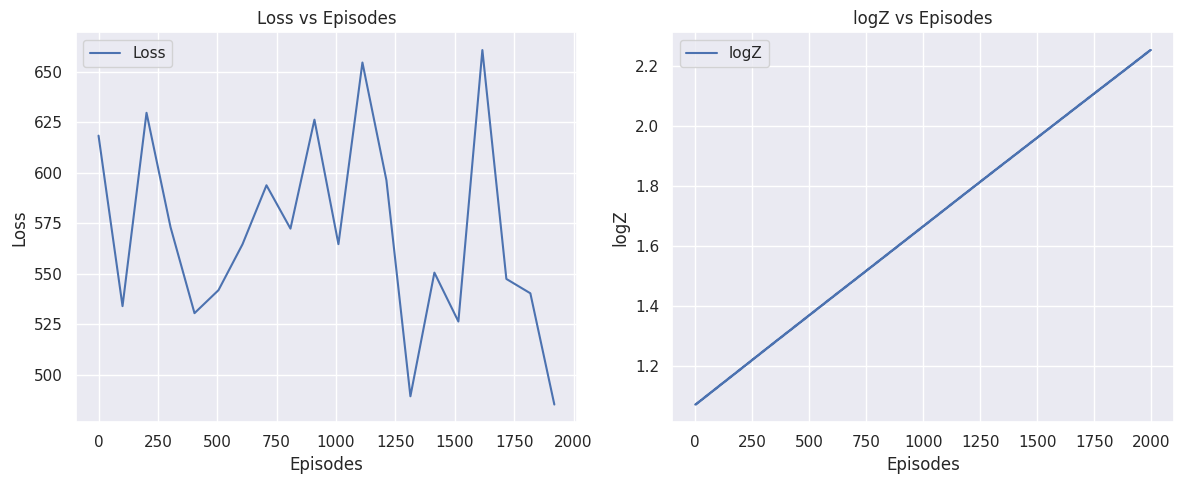

In [88]:
# losses vs episodes and logZs vs episodes
step_losses = np.array(losses)
steps = range(0, len(step_losses), 101)
step_losses = step_losses[steps]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(steps, step_losses, label='Loss')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.title('Loss vs Episodes')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(logZs, label='logZ')
plt.xlabel('Episodes')
plt.ylabel('logZ')
plt.title('logZ vs Episodes')
plt.legend()

plt.tight_layout()
plt.show()

### 3.4 Generating MOFs with GFlowNet

In [96]:
agent.eval()
num_samples = 5
generated_sequences = []
generated_rewards = []

for i in range(num_samples):
    with torch.no_grad():
        obs, info, reward, _ = agent.sample(grad=False)
        sequence = info["sequence"][:-1]
        generated_sequences.append(sequence)
        generated_rewards.append(reward)
        
details = []
for i, seq in enumerate(generated_sequences):
    structure = ffc_builder.make_structure(seq)
    affine = calculate_co2_affinity(structure)
    sa = rewarder.reward(seq)
    vf = calculate_void_fraction(structure)
    reward = generated_rewards[i]
    details.append({
        'sequence': seq,
        'reward': reward,
        'void_fraction': vf,
        'co2_affinity': affine,
        'surface_area': sa
    })
    

for i, detail in enumerate(details):
    print(f"Sequence {i + 1}: {detail['sequence']}")
    print(f"Reward: {detail['reward']:.4f}")
    print(f"Void Fraction: {detail['void_fraction']:.4f}")
    print(f"CO2 Affinity: {detail['co2_affinity']:.4f}")
    print(f"Surface Area: {detail['surface_area']:.4f}")
    print("-" * 40)

Sequence 1: ['N330', 'N365', 'N429', 'E156', 'E114']
Reward: 170.6068
Void Fraction: 0.9943
CO2 Affinity: 0.0925
Surface Area: 340.5800
----------------------------------------
Sequence 2: ['N455', 'N282', 'N20', 'E188', 'E176']
Reward: 171.1889
Void Fraction: 0.9941
CO2 Affinity: 0.0864
Surface Area: 341.7468
----------------------------------------
Sequence 3: ['N710', 'N455', 'N130', 'E63', 'E10']
Reward: 81.6713
Void Fraction: 0.9924
CO2 Affinity: 0.1780
Surface Area: 162.6759
----------------------------------------
Sequence 4: ['N524', 'N710', 'N10', 'E131', 'E130']
Reward: 35.6618
Void Fraction: 0.9837
CO2 Affinity: 0.1038
Surface Area: 70.6918
----------------------------------------
Sequence 5: ['N317', 'N417', 'N410', 'E155', 'E31']
Reward: 23.9114
Void Fraction: 0.9916
CO2 Affinity: 0.2471
Surface Area: 47.1291
----------------------------------------


### 3.5 Comparsion of trained and randon genreation

**Limitation**: Since trained on less episodes and also having loss 500. The trained model will not give correct sequences

**Increase in Episodes and change in loss backprop will improve model**

In [97]:
from tqdm import tqdm

In [99]:
# Even with limitation will compare the geneartion of MOFs
agent.eval()
num_samples = 1000
agent_sequences = []
generated_sequences = []

for i in tqdm(range(num_samples)):
    generated_sequences.append(ffc_builder.random_sequence())
    with torch.no_grad():
        obs, info, reward, _ = agent.sample(grad=False)
        sequence = info["sequence"][:-1]
        agent_sequences.append(sequence)

100%|██████████| 1000/1000 [26:24<00:00,  1.58s/it]


In [100]:
generated_surface_areas = []
generated_void_fractions = []
generated_co2_affinities = []
agent_surface_areas = []
agent_void_fractions = []
agent_co2_affinities = []

for seq in tqdm(generated_sequences):
    structure = ffc_builder.make_structure(seq)
    generated_surface_areas.append(rewarder.reward(seq))
    generated_void_fractions.append(calculate_void_fraction(structure))
    generated_co2_affinities.append(calculate_co2_affinity(structure))
    
for seq in tqdm(agent_sequences):
    structure = ffc_builder.make_structure(seq)
    agent_surface_areas.append(rewarder.reward(seq))
    agent_void_fractions.append(calculate_void_fraction(structure))
    agent_co2_affinities.append(calculate_co2_affinity(structure))

 17%|█▋        | 168/1000 [04:14<18:32,  1.34s/it]


100%|██████████| 1000/1000 [23:57<00:00,  1.44s/it]


In [120]:
contributions = {
    'sa': 0.5, # Surface area
    'vf': 0.3, # Void fraction
    'affine': 0.2 # CO2 affinity
}

generated_rewards = ((np.array(generated_surface_areas) * contributions['sa']) + 
                     (np.array(generated_void_fractions) * contributions['vf']) + 
                     (np.array(generated_co2_affinities) * contributions['affine']))

agent_rewards = (np.array(agent_surface_areas) * contributions['sa'] + 
                 np.array(agent_void_fractions) * contributions['vf'] + 
                 np.array(agent_co2_affinities) * contributions['affine'])

In [121]:
agent_rewards.mean(), agent_rewards.std(), agent_rewards.max(), agent_rewards.min()

(146.12730004710022, 143.7219696294348, 1272.812388263846, 2.1138261271393803)

In [122]:
generated_rewards.mean(), generated_rewards.std(), generated_rewards.max(), generated_rewards.min()

(142.46093441812218, 158.30190088101767, 1412.545273445806, 2.6098871963644443)

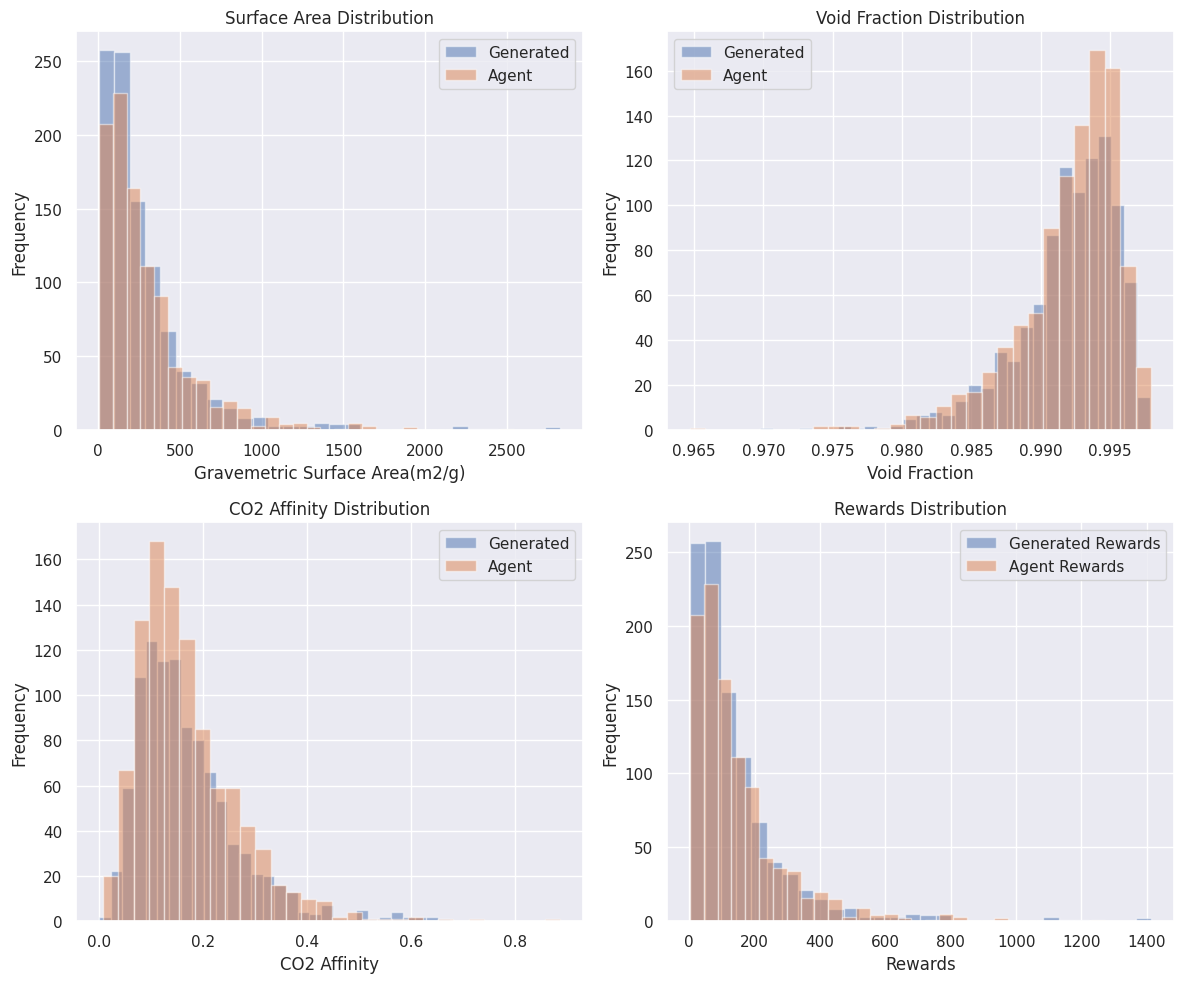

In [124]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.hist(generated_surface_areas, bins=30, alpha=0.5, label='Generated')
plt.hist(agent_surface_areas, bins=30, alpha=0.5, label='Agent')
plt.xlabel('Gravemetric Surface Area(m2/g)')
plt.ylabel('Frequency')
plt.title('Surface Area Distribution')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(generated_void_fractions, bins=30, alpha=0.5, label='Generated')
plt.hist(agent_void_fractions, bins=30, alpha=0.5, label='Agent')
plt.xlabel('Void Fraction')
plt.ylabel('Frequency')
plt.title('Void Fraction Distribution')
plt.legend()

plt.subplot(2, 2, 3)
plt.hist(generated_co2_affinities, bins=30, alpha=0.5, label='Generated')
plt.hist(agent_co2_affinities, bins=30, alpha=0.5, label='Agent')
plt.xlabel('CO2 Affinity')
plt.ylabel('Frequency')
plt.title('CO2 Affinity Distribution')
plt.legend()

plt.subplot(2, 2, 4)
plt.hist(generated_rewards, bins=30, alpha=0.5, label='Generated Rewards')
plt.hist(agent_rewards, bins=30, alpha=0.5, label='Agent Rewards')
plt.xlabel('Rewards')
plt.ylabel('Frequency')
plt.title('Rewards Distribution')
plt.legend()

plt.tight_layout()
plt.show()

# 4. CO<sub>2</sub> Adsorption using Raspa Monte Carlo Method

- There is a Raspa library that can use different simulations for CO<sub>2</sub> uptake.

In [ ]:
import os
import subprocess
import re
import pandas as pd
import shutil
import glob

def write_raspa_input(sim_dir, cif_name, temperature, pressure, n_cycles=50000):
    tpl = f"""
SimulationType                    MonteCarlo
NumberOfInitializationCycles      {int(n_cycles * 0.2)}
NumberOfCycles                    {n_cycles}
PrintEvery                        {int(n_cycles * 0.01)}

Forcefield                        GenericMOFs
Framework 0                      {cif_name}

Component 0 MoleculeName          CO2
Component 0 MoleculeDefinition    TraPPE
ExternalTemperature               {temperature}  # K
ExternalPressure                  {pressure}     # Pa
    """.strip()
    with open(os.path.join(sim_dir, "simulation.input"), "w") as f:
        f.write(tpl)


def run_gcmc_on_structures(cifs, pressures, temperature=298.0):
    records = []
    # Ensure scratch directory exists in current working directory
    scratch_root = os.path.join(os.getcwd(), 'scratch')
    os.makedirs(scratch_root, exist_ok=True)

    for idx, cif_text in enumerate(cifs, start=1):
        for p in pressures:
            # Create a unique scratch subdirectory for this run
            sim_dir = os.path.join(scratch_root, f'struct_{idx}_p_{p}')
            os.makedirs(sim_dir, exist_ok=True)

            # Write CIF file
            cif_name = f'struct_{idx}.cif'
            cif_path = os.path.join(sim_dir, cif_name)
            with open(cif_path, 'w') as f:
                f.write(cif_text)

            # Write Raspa input
            write_raspa_input(sim_dir, cif_name, temperature, p)

            # Run RASPA in the scratch subdirectory
            subprocess.run(
                ['raspa', '-i', 'simulation.input'],
                cwd=sim_dir, check=True
            )

            # Parse output
            uptake = None
            out_pattern = os.path.join(sim_dir, 'Output', '**', 'adsorption_isotherm.txt')
            for out_file in glob.glob(out_pattern, recursive=True):
                with open(out_file) as txtf:
                    txt = txtf.read()
                m = re.search(r"loading\s*=\s*([\d\.]+)\s*mmol/g", txt)
                if m:
                    uptake = float(m.group(1))
                    break

            records.append({
                'structure_index': idx,
                'pressure_Pa': p,
                'uptake_mmol_per_g': uptake
            })

            # Clean up the scratch subdirectory for this run
            shutil.rmtree(sim_dir)

    return pd.DataFrame(records)

In [ ]:
split_seq = agent_sequences[:4]
cifs = []
for i, seq in enumerate(split_seq):
    cif_text = ffc_builder.make_cif(seq)
    cifs.append(cif_text)

In [ ]:
pressures = [1e4, 5e4, 1e5, 5e5, 1e6]
df = run_gcmc_on_structures(cifs, pressures)